In [1]:
import numpy as np
import sys
sys.path.append("../../")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_all = pd.concat( [df_IEA_train, df_IEA_test] )

In [3]:
df = utility.load_longitudinal()

df_used = pd.merge(df, df_IEA_all, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [4]:
independent = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']
models = []

In [5]:
p_values = []

cov_dict = {iii:[] for iii in independent}
exp_cov_dict = {iii:[] for iii in independent}
            
    
for ccc in ["Frequent_Exacerbator_P2", "Frequent_Exacerbator_P3"]:
    X = df_used[independent
               ]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx]
    
    X = sm.add_constant(X.apply(stats.zscore))
    
    
    M_logit = sm.Logit(y, X).fit()

    models.append(M_logit)

    
    
    v = M_logit.summary2().tables[1].values
    
    
    for iii in range(1, len(independent) + 1):
        col = independent[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict[col].append(eee + CI1)

        
        col = independent[iii-1]
        eee = "{:.2f}".format( np.exp( v[iii, 0]) )
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI2 = "({:.2f}, {:.2f})".format( np.exp(v[iii, 4]), np.exp(v[iii, 5]))
        
        exp_cov_dict[col].append(eee + CI2)
        
    

Optimization terminated successfully.
         Current function value: 0.201084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152929
         Iterations 8


In [6]:
df_used = df_used[ ["days_P2", "vital_status"] + independent ]

df_used = df_used[~df_used.isnull().any(1)]
df_used[ independent ] = df_used[ independent ].apply(stats.zscore)

M = CoxPHFitter(penalizer = 0., l1_ratio=0.5)
M.fit(df_used, duration_col = "days_P2", event_col = "vital_status")


models.append(M)

v = M.summary

for col in v.index:
    eee = "{:.2f}".format( v.loc[col, "coef"] )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "({:.2f}, {:.2f})".format(v.loc[col, "coef lower 95%"], v.loc[col, "coef upper 95%"])

    cov_dict[col].append(eee + CI1)

    eee = "{:.2f}".format( np.exp( v.loc[col, "coef"] ) )
    ppp =  v.loc[col, "p"]
    if ppp<.05:
        eee += "*"
    if ppp<.01:
        eee += "*"
    if ppp<.001:
        eee += "*"

    CI1 = "({:.2f}, {:.2f})".format( np.exp( v.loc[col, "coef lower 95%"]), np.exp(v.loc[col, "coef upper 95%"]))

    exp_cov_dict[col].append(eee + CI1)
    

# Generate the table

In [7]:
rows = ["Frequent_Exacerbator_P2", "Frequent_Exacerbator_P3", "Mortality"
       ]

cols = ["$\\beta_{IEA_{emph}}$ (95%CI)" , "Odds / Hazard Ratio", "$\\beta_{IEA_{airway}}$ (95%CI)", "Odds / Hazard Ratio" ]


In [8]:
betas = np.array(
    [cov_dict["IEA0"], exp_cov_dict["IEA0"], cov_dict["IEA1"], exp_cov_dict["IEA1"],]
).T



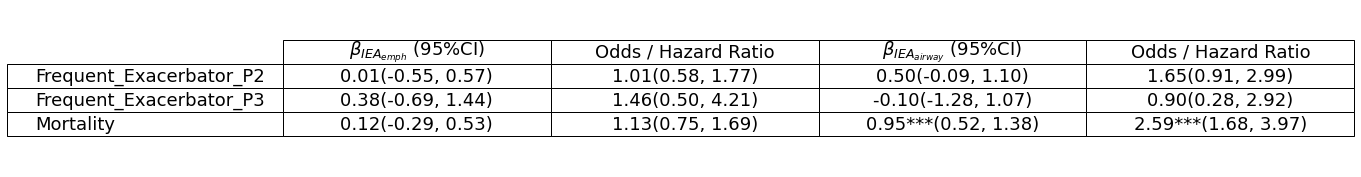

In [9]:
fig, ax = plt.subplots(figsize=(16,3))

the_table=plt.table(cellText=betas, rowLabels=rows, 
                    colLabels = cols,
                     colWidths = [.15]*betas.shape[1], loc='center', cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)